<a href="https://colab.research.google.com/github/aimalz/CASTORpz/blob/main/Stratify_by_tav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stratifying Information


_Alex Malz (CMU) & Bryan Scott (NU)_

What kinds of galaxies are most and least affected by the addition of UV photometry?


##Preliminaries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from astropy.table import Table
prepend = '/content/drive/MyDrive/Research/CASTORpz/'
unp = Table.read(prepend+"unperturbed_mags.fits")
print(len(unp))

# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# !pip install jaxlib==0.4.16
# !pip install jax==0.4.16

# jaxlib==0.3.22+cuda11.cudnn82

# !pip install jax[cuda]==0.4.17+cuda12.cudnn89 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# !pip install "jax[cuda]"==0.4.16
!nvcc --version

!pip install astropy pzflow corner

from pzflow import Flow
import jax.numpy as jnp
import pandas as pd
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds
import scipy.stats as sps

Mounted at /content/drive
698211
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00


In [3]:
cd /content/drive/MyDrive/Research/CASTORpz


/content/drive/.shortcut-targets-by-id/16x7U5T_UymL5W1hrOq7ELHaADZbsYBNb/CASTORpz


## Define Catalogs and Magnitudes

In [4]:
unp = Table.read(prepend+"unperturbed_mags.fits").to_pandas()#.set_index('ID')
mock = Table.read(prepend+"ext_phot.fits").to_pandas()#.set_index('ID')

names_phot = ["ID", "photoz",
              "LSST_g_MAG", "LSST_g_MAGERR",
              "LSST_r_MAG", "LSST_r_MAGERR",
              "LSST_i_MAG", "LSST_i_MAGERR",
              "LSST_z_MAG", "LSST_z_MAGERR",
              "castor_uv_MAG", "castor_uv_MAGERR",
              "castor_u_MAG", "castor_u_MAGERR",
              "castor_g_MAG", "castor_g_MAGERR",
              "Euclid_VIS_MAG",
              'Euclid_Y_MAG','Euclid_J_MAG','Euclid_H_MAG',
              'Roman_106_MAG',
              'Roman_129_MAG','Roman_158_MAG',
              'Roman_184_MAG']

In [5]:
# load data

# ask Bobby about this

def getTrueY(test_cat, mag_col_names, y_col_name):
    test_cat = Table(test_cat, masked=True, copy=True)
    # remove nans
    for col in mag_col_names:
        test_cat[col].mask = np.isnan(test_cat[col].data) | test_cat[col].mask
        test_cat = test_cat[~test_cat[col].mask] # then remove nans from test set

    true_y = test_cat[y_col_name]
    return true_y.filled()

In [6]:
# from non-draft Octflows
os_combo_labels = {'LSST-only': 'LSST',
                  'CASTOR-only': 'CASTOR',
                  'Roman-only': 'Roman',
                  'Euclid-only': 'Euclid',
                  'LSST+CASTOR': 'LSST+CASTOR',
                  'Euclid+LSST': 'LSST+Euclid',
                  'Roman+LSST': 'LSST+Roman',
                  'Euclid+CASTOR': 'Euclid+CASTOR',
                  'Roman+CASTOR': 'Roman+CASTOR',
                  # 'Euclid+Roman': 'Euclid+Roman',
                  # 'Roman+LSST+CASTOR' : 'LSST+Roman+CASTOR',
                  # 'Roman+Euclid+CASTOR': 'Roman+Euclid+CASTOR',
                  'Euclid+LSST+CASTOR': 'LSST+Euclid+CASTOR',
                  # 'Roman+Euclid+LSST': 'LSST+Roman+Euclid',
                  'Roman+Euclid+LSST+CASTOR': 'LSST+Roman+Euclid+CASTOR'}

available_os = os_combo_labels.keys()

In [7]:
mock_cat = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG"]], on='ID')
# CASTOR_baseline = Table.from_pandas(mock_cat)
CASTOR_baseline = Table.from_pandas(mock_cat[(mock_cat["Euclid_VIS_MAG"] <= 24.5) & (mock_cat["LSST_r_MAG"] >= 17.5)]) # apply magnitude limit cuts

In [8]:
# put data in expected format for TLM

# LSST_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_u_MAG")
LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")
# LSST_y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_y_MAG")

# LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
# LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
# LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
# LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAG")
CASTOR_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAG")
CASTOR_uv_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAG")

# CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAGERR")
# CASTOR_u_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAGERR")
# CASTOR_uv_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAGERR")

Euclid_VIS_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_VIS_MAG")
Euclid_J_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_J_MAG")
Euclid_H_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_H_MAG")
Euclid_Y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_Y_MAG")

# Roman - only a subset of the Roman filters are available?

# Roman_062_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_062_MAG')
# Roman_087_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_087_MAG')
Roman_106_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_106_MAG')

Roman_129_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_129_MAG')
# Roman_146_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_146_MAG')
Roman_158_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_158_MAG')

Roman_184_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_184_MAG')
# Roman_213_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_213_MAG')

ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")

In [9]:
which_cols = {}
which_cols['LSST'] = {'r': LSST_r_mag,
                            #  'u-g': LSST_u_mag - LSST_g_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                            #  'z-y': LSST_z_mag - LSST_y_mag,
                      }
which_cols['CASTOR'] = {'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag}
which_cols['Roman'] = {'106': Roman_106_mag,
                             '129 - 106': Roman_129_mag - Roman_106_mag,
                             '158-129': Roman_158_mag - Roman_129_mag,
                             '184-158': Roman_184_mag - Roman_158_mag}
which_cols['Euclid'] = { 'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag}

In [10]:
test_catalogs = {}
test_catalogs['LSST-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['CASTOR-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
# test_catalogs['Euclid+Roman'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
# test_catalogs['Roman+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
# test_catalogs['Roman+Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
# test_catalogs['Roman+Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()

In [11]:
catalogs = test_catalogs

## Read Pre-trained Flows

Evaluating the log probabilities is very slow!

In [ ]:
# flows = {}
# just_tav = {}
# for os in available_os:
#   flows[os] = FlowEnsemble(file=f"Oct_flowspzflow_ensemble_for_{os}.pkl")
#   just_tav[os] = flows[os].log_prob(catalogs[os])
#   catalogs[os]['log_prob'] = just_tav[os]
#   with (open(f"{os}_with_tav.pkl", 'wb')) as openfile:
#     pickle.dump(catalogs[os], openfile)

In [12]:
tav_cats = {}
just_tav = {}
for os in available_os:
  # print(os)
  with (open(f"{os}_with_tav.pkl", 'rb')) as openfile:
    tav_cats[os] = pd.read_pickle(openfile)
    # print(tav_cats[os].columns)
    just_tav[os] = tav_cats[os]['log_prob']

commenting out until I/we have a chance to investigate flow errors a bit more

In [ ]:
# losses = {}
# for os in available_os:
#   with (open(f"losses_for_{os}.pkl", 'rb')) as openfile:
#     losses[os] = pd.read_pickle(openfile)

# flow_list = list(np.linspace(0, 29, 30).astype(int))
# bad_flows = {}

# for os in available_os:
#   bad_flows_list = []
#   for flow in flow_list:
#     if np.sum(np.isinf(np.array(losses[os]['losses'][f"Flow {flow}"]))) > 0:
#       bad_flows_list.append(flow)
#     bad_flows[os] = bad_flows_list

In [ ]:
# clean_tav = {}

# for os in available_os:
#   clean_tav[os] = np.delete(just_tav[os], bad_flows[os], axis = 1)

quick visualization of tav and delta tav for single survey vs with castor

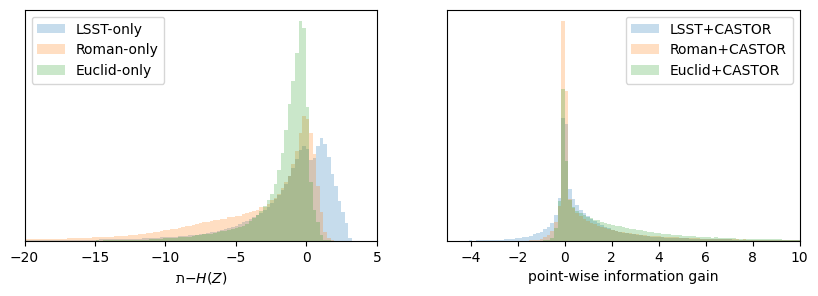

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))#, sharex=True)
delta_tav_agg = []
# which_plt = 0
# for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
#   ax[which_plt].hist(tav_cats[os]['z_true'], alpha=0.25, label=os[:-5], density=True, bins=100)
#   ax[which_plt].legend()
#   ax[which_plt].set_xlim(0, 5)
#   ax[which_plt].set_xlabel(r'$z$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#   ax[which_plt].set_yticks([])
which_plt = 0
for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
  delta_tav_agg.append(just_tav[os])
  ax[which_plt].hist(just_tav[os][np.isfinite(just_tav[os])], alpha=0.25, label=os, density=True, bins=np.linspace(-20, 5, 100))
  ax[which_plt].legend()
  ax[which_plt].set_xlim(-20, 5)
  ax[which_plt].set_xlabel(chr(0x05ea)+r'$-H(Z)$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  ax[which_plt].set_yticks([])
which_plt = 1
for i, os in enumerate(['LSST+CASTOR', 'Roman+CASTOR', 'Euclid+CASTOR']):
  delta_tav_agg[i] = np.exp(just_tav[os]) * (just_tav[os] - delta_tav_agg[i])
  ax[which_plt].hist(delta_tav_agg[i][np.isfinite(delta_tav_agg[i])], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 10, 100))
  ax[which_plt].legend()
  ax[which_plt].set_xlim(-5, 10)
  ax[which_plt].set_xlabel('point-wise information gain') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  ax[which_plt].set_yticks([])


fig.show()

the LSST-only ones don't improve as much because they're already much better than Roman and Euclid because of u-band depth

more get worse because higher dimensionality effectively dilutes information unless it's adding something new, noisifying

In [15]:
help(sps.ecdf)

Help on function ecdf in module scipy.stats._survival:

ecdf(sample: 'npt.ArrayLike | CensoredData') -> 'ECDFResult'
    Empirical cumulative distribution function of a sample.
    
    The empirical cumulative distribution function (ECDF) is a step function
    estimate of the CDF of the distribution underlying a sample. This function
    returns objects representing both the empirical distribution function and
    its complement, the empirical survival function.
    
    Parameters
    ----------
    sample : 1D array_like or `scipy.stats.CensoredData`
        Besides array_like, instances of `scipy.stats.CensoredData` containing
        uncensored and right-censored observations are supported. Currently,
        other instances of `scipy.stats.CensoredData` will result in a
        ``NotImplementedError``.
    
    Returns
    -------
    res : `~scipy.stats._result_classes.ECDFResult`
        An object with the following attributes.
    
        cdf : `~scipy.stats._result_classes.

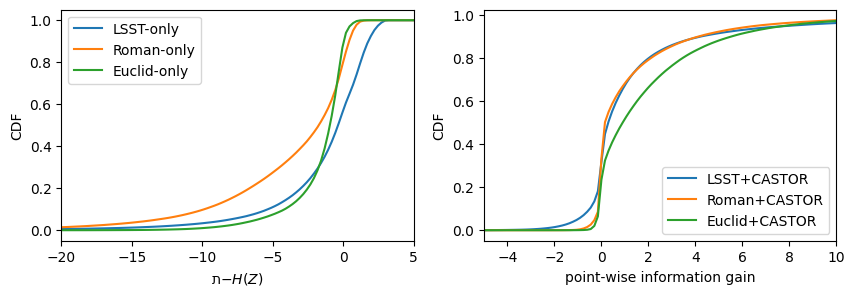

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))#, sharex=True)
delta_tav_agg = []
# which_plt = 0
# for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
#   ax[which_plt].hist(tav_cats[os]['z_true'], alpha=0.25, label=os[:-5], density=True, bins=100)
#   ax[which_plt].legend()
#   ax[which_plt].set_xlim(0, 5)
#   ax[which_plt].set_xlabel(r'$z$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#   ax[which_plt].set_yticks([])
which_plt = 0
for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
  delta_tav_agg.append(just_tav[os])
  xran = np.linspace(-20, 5, 100)
  to_plot = sps.ecdf(just_tav[os][np.isfinite(just_tav[os])]).cdf.evaluate(xran)
  ax[which_plt].plot(xran, to_plot, label=os)
  ax[which_plt].legend()
  ax[which_plt].set_xlim(-20, 5)
  ax[which_plt].set_xlabel(chr(0x05ea)+r'$-H(Z)$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  # ax[which_plt].set_yticks([])
  ax[which_plt].set_ylabel('CDF')
which_plt = 1
for i, os in enumerate(['LSST+CASTOR', 'Roman+CASTOR', 'Euclid+CASTOR']):
  delta_tav_agg[i] = np.exp(just_tav[os]) * (just_tav[os] - delta_tav_agg[i])
  xran = np.linspace(-5, 10, 100)
  to_plot = sps.ecdf(delta_tav_agg[i][np.isfinite(delta_tav_agg[i])]).cdf.evaluate(xran)
  ax[which_plt].plot(xran, to_plot, label=os)
  ax[which_plt].legend()
  ax[which_plt].set_xlim(-5, 10)
  ax[which_plt].set_xlabel('point-wise information gain') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  # ax[which_plt].set_yticks([])
  ax[which_plt].set_ylabel('CDF')

fig.show()

## Existing Attempts to Stratify by Information Metric

### attempt to stratify by change in information when adding additional bands

In [21]:
delta_tav_dict, kld_lo, kld_hi = {}, {}, {}

for i, os in enumerate(['LSST+CASTOR', 'Roman+CASTOR', 'Euclid+CASTOR']):
  delta_tav_dict[os] = delta_tav_agg[i][np.isfinite(delta_tav_agg[i])]
  kld_lo[os] = np.percentile(delta_tav_dict[os], 0.1)
  kld_hi[os] = np.percentile(delta_tav_dict[os], 99.9)
  print(os, kld_lo[os], kld_hi[os])

LSST+CASTOR -4.218192071914673 39.43550849914682
Roman+CASTOR -1.2381391658782959 32.80173735046478
Euclid+CASTOR -0.7557239183187485 22.473199102401907


In [22]:
improved = {}
worsened = {}
for i, os in enumerate(['LSST+CASTOR', 'Roman+CASTOR', 'Euclid+CASTOR']):
  improved[os] = delta_tav_dict[os][delta_tav_dict[os] >= kld_hi[os]]
  # improved[os] = delta_tav_dict[os][delta_tav_dict[os] >= 10.]
  worsened[os] = delta_tav_dict[os][delta_tav_dict[os] <= kld_lo[os]]

selecting most and least improved tenth of a percentile by KLD


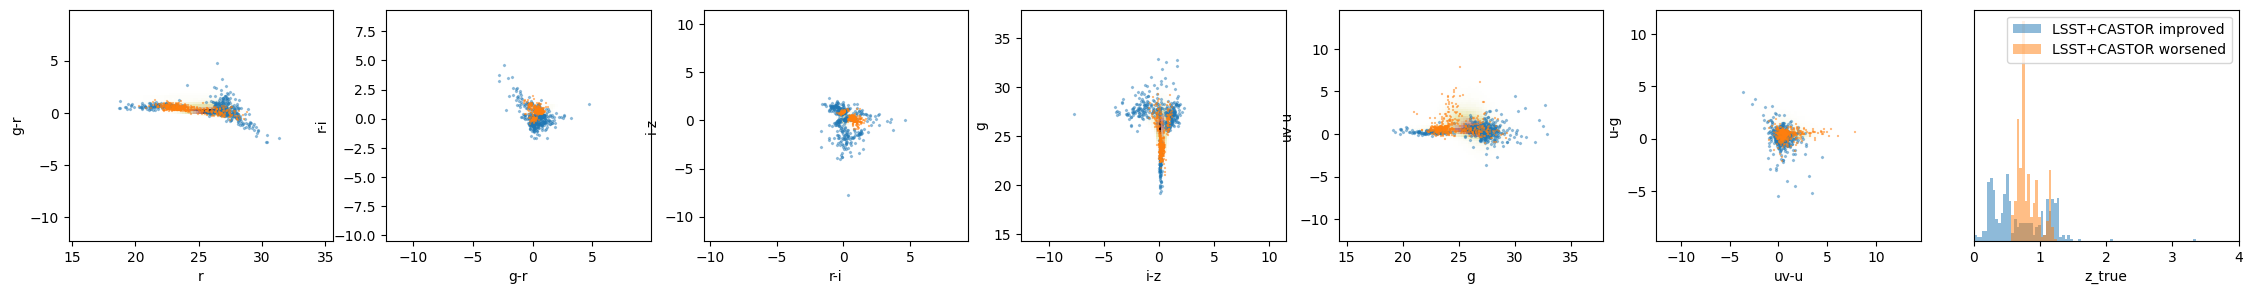

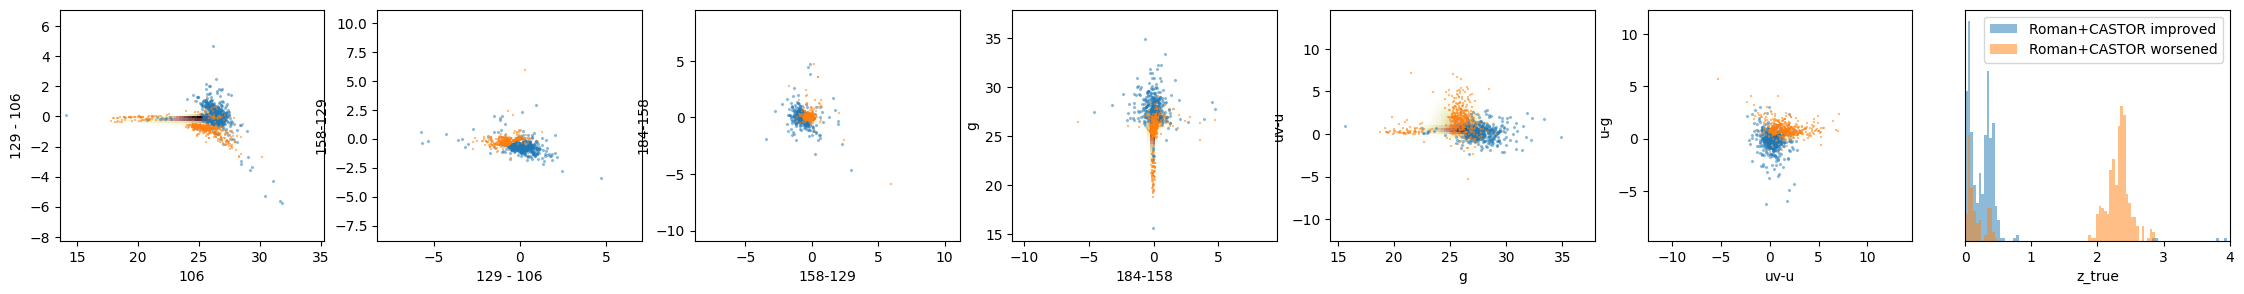

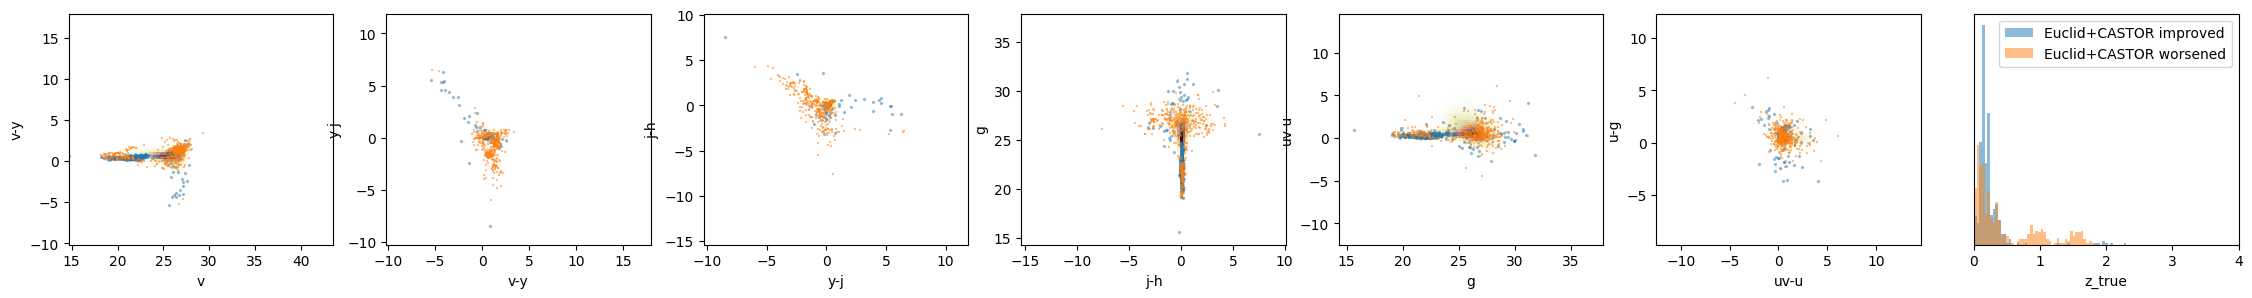

In [23]:
# fig, ax = plt.subplots(1, 4, figsize = (18, 4))
# i=1

# colors_lsst = ['g-r', 'r-i', 'i-z', 'uv-u', 'u-g']

# plt.suptitle('Best and Worst Galaxies in LSST+CASTOR (by absolute value of TLM)')
print('selecting most and least improved tenth of a percentile by KLD')

for j, os in enumerate(['LSST+CASTOR', 'Roman+CASTOR', 'Euclid+CASTOR']):
  subset = tav_cats[os].drop(['z_true', 'log_prob'], axis=1)
  tot_plots = len(subset.columns)
  fig, ax = plt.subplots(1, tot_plots, figsize = (tot_plots * 4, 3))
  # i=1
  for i, color_col in enumerate(subset.columns.values[:-1]):
    ax[i].hist2d(tav_cats[os][color_col], tav_cats[os][subset.columns[i+1]], cmap='pink_r', bins=(100, 100))
    ax[i].scatter(tav_cats[os][color_col][improved[os].index], tav_cats[os][subset.columns[i+1]][improved[os].index], label = os+' improved', s = 2, marker = 'x', alpha=0.5)
    ax[i].scatter(tav_cats[os][color_col][worsened[os].index], tav_cats[os][subset.columns[i+1]][worsened[os].index], label = os+' worsened', s = 2, marker = '+', alpha = 0.5)
    ax[i].set_xlabel(color_col)
    ax[i].set_ylabel(subset.columns.values[i+1])
  ax[i+1].hist(tav_cats[os]['z_true'][improved[os].index], bins=np.linspace(0, 4, 100), label = os+' improved', alpha=0.5, density=True)
  ax[i+1].hist(tav_cats[os]['z_true'][worsened[os].index], bins=np.linspace(0, 4, 100), label = os+' worsened', alpha=0.5, density=True)
  ax[i+1].set_xlabel('z_true')
  ax[i+1].set_yticks([])
  ax[i+1].set_xlim(0, 4)
  plt.legend()

  # i = i + 1
  fig.show()

let's inspect some of those weird populations

In [27]:
os = 'LSST+CASTOR'

LSST_lo_z_good = tav_cats[os].loc[improved[os].index][tav_cats[os]['z_true'] < 0.3]
LSST_lm_z_good = tav_cats[os].loc[improved[os].index][(tav_cats[os]['z_true'] > 0.3) & (tav_cats[os]['z_true'] < 0.5)]
LSST_hm_z_good = tav_cats[os].loc[improved[os].index][(tav_cats[os]['z_true'] > 0.5) & (tav_cats[os]['z_true'] < 1.05)]
LSST_hi_z_good = tav_cats[os].loc[improved[os].index][tav_cats[os]['z_true'] > 1.05]

print(LSST_lo_z_good.index)
print(LSST_lm_z_good.index)
print(LSST_hm_z_good.index)
print(LSST_hi_z_good.index)

Index([ 36532,  43717,  48354,  57171,  73728,  83825,  84792,  85160,  90373,
       100675, 102507, 102945, 108541, 111079, 118152, 122516, 130390, 134333,
       162457, 169594, 170012, 178024, 218397, 232940, 265479, 267281, 273109,
       276374, 278504, 281666, 306531, 306633, 315475, 317730, 321885, 341863,
       349552, 385721, 389091, 393632, 410920, 417960, 435162, 494688, 502518,
       516819, 536171, 557106, 576145, 581523, 591053, 594205, 598968, 664654,
       671516, 681174, 682094, 700158, 711359, 712228, 712229, 738588, 738737,
       742901, 744298, 750348, 753424, 766051, 768605, 781636, 785308, 807848,
       822321, 824173, 833472, 835308, 835616, 849465, 885742, 893690, 896888,
       903609, 904467, 916288, 923406, 923575, 934849, 937367, 939051, 942740],
      dtype='int64', name='CASTOR_ID')
Index([  3681,  20183,  21572,  62342,  73634,  75088, 115080, 119341, 140809,
       142231, 144583, 159080, 160775, 199565, 206203, 216270, 231350, 250303,
       26745

<ipython-input-27-e17a440baa52>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LSST_lo_z_good = tav_cats[os].loc[improved[os].index][tav_cats[os]['z_true'] < 0.3]
<ipython-input-27-e17a440baa52>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LSST_lm_z_good = tav_cats[os].loc[improved[os].index][(tav_cats[os]['z_true'] > 0.3) & (tav_cats[os]['z_true'] < 0.5)]
<ipython-input-27-e17a440baa52>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LSST_hm_z_good = tav_cats[os].loc[improved[os].index][(tav_cats[os]['z_true'] > 0.5) & (tav_cats[os]['z_true'] < 1.05)]
<ipython-input-27-e17a440baa52>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  LSST_hi_z_good = tav_cats[os].loc[improved[os].index][tav_cats[os]['z_true'] > 1.05]


In [26]:
# high vs low redshift weirdos in worsened roman+castor
# hypothesis: high-z are already well-constrained by roman and just noisified by
# higher dimensionality, if so would be flat in uv-u past break

os = 'Roman+CASTOR'

Roman_lo_z_bad = tav_cats[os].loc[worsened[os].index][tav_cats[os]['z_true'] < 0.25]
Roman_mid_z_bad = tav_cats[os].loc[worsened[os].index][(tav_cats[os]['z_true'] > 0.25) & (tav_cats[os]['z_true'] < 1.)]
Roman_hi_z_bad = tav_cats[os].loc[worsened[os].index][tav_cats[os]['z_true'] > 1.]

print(Roman_lo_z_bad.index)
print(Roman_mid_z_bad.index)
print(Roman_hi_z_bad.index)

Index([  1499,   6185,   6322,  14116,  44157,  61158,  84745,  91326,  93355,
       106517, 130706, 138807, 169449, 197448, 225874, 229233, 230291, 254331,
       258740, 269513, 288769, 290033, 299664, 300742, 310397, 317195, 325343,
       325959, 344163, 351187, 373891, 390701, 391096, 392188, 402783, 405296,
       422730, 428795, 452122, 512165, 516488, 526537, 540343, 563867, 568223,
       587820, 598496, 608606, 631003, 636064, 638254, 645380, 647185, 650655,
       667542, 678388, 691811, 694444, 718373, 724460, 737152, 741036, 743118,
       743189, 765472, 765593, 770091, 777946, 782009, 789326, 793634, 797074,
       815044, 828528, 848510, 870862, 871184, 882423, 884736, 886847, 896997,
       897088, 901182, 912591, 912882, 953608],
      dtype='int64', name='CASTOR_ID')
Index([ 21133, 103073, 126067, 146109, 198654, 208722, 296596, 302962, 306372,
       370979, 422124, 435675, 457275, 464439, 515009, 526336, 567491, 627946,
       646864, 723419, 808730, 845560, 86925

<ipython-input-26-dc61e48dd177>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Roman_lo_z_bad = tav_cats[os].loc[worsened[os].index][tav_cats[os]['z_true'] < 0.25]
<ipython-input-26-dc61e48dd177>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Roman_mid_z_bad = tav_cats[os].loc[worsened[os].index][(tav_cats[os]['z_true'] > 0.25) & (tav_cats[os]['z_true'] < 1.)]
<ipython-input-26-dc61e48dd177>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Roman_hi_z_bad = tav_cats[os].loc[worsened[os].index][tav_cats[os]['z_true'] > 1.]


In [28]:
# looks like there will be one population with flat j-h, bet that's the low-z one
# will be interesting to compare the low-z one to the improved population

os = 'Euclid+CASTOR'

Euclid_lo_z_bad = tav_cats[os].loc[worsened[os].index][tav_cats[os]['z_true'] < 0.6]
Euclid_mid_z_bad = tav_cats[os].loc[worsened[os].index][(tav_cats[os]['z_true'] > 0.6) & (tav_cats[os]['z_true'] < 1.25)]
Euclid_hi_z_bad = tav_cats[os].loc[worsened[os].index][tav_cats[os]['z_true'] > 1.25]

print(Euclid_lo_z_bad.index)
print(Euclid_mid_z_bad.index)
print(Euclid_hi_z_bad.index)

Index([   147,   4798,   6322,   9375,  13623,  18911,  32851,  37667,  39938,
        42181,
       ...
       943676, 947165, 948443, 948472, 949321, 949913, 951914, 952593, 959070,
       964420],
      dtype='int64', name='CASTOR_ID', length=307)
Index([ 15214,  31554,  73273,  89772,  90817, 102329, 104737, 106536, 112462,
       114701, 128874, 144085, 190098, 204803, 217074, 241781, 273430, 278216,
       279259, 286407, 287356, 297007, 302567, 307796, 316090, 320776, 333503,
       338591, 363602, 370793, 398339, 403499, 424787, 430209, 431714, 455420,
       456549, 458967, 497804, 507441, 508274, 544667, 569384, 575027, 575368,
       579336, 579598, 582837, 629394, 672050, 676874, 723469, 744203, 750466,
       755211, 775465, 777377, 815827, 822484, 834887, 853086, 859142, 864401,
       867797, 878285, 903102, 910521, 911293, 942491, 956542],
      dtype='int64', name='CASTOR_ID')
Index([ 27679,  40236,  54137,  89684,  93101, 104507, 114692, 133392, 166323,
       210338,

<ipython-input-28-8bf52324ace1>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Euclid_lo_z_bad = tav_cats[os].loc[worsened[os].index][tav_cats[os]['z_true'] < 0.6]
<ipython-input-28-8bf52324ace1>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Euclid_mid_z_bad = tav_cats[os].loc[worsened[os].index][(tav_cats[os]['z_true'] > 0.6) & (tav_cats[os]['z_true'] < 1.25)]
<ipython-input-28-8bf52324ace1>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Euclid_hi_z_bad = tav_cats[os].loc[worsened[os].index][tav_cats[os]['z_true'] > 1.25]


what if we define best differently to get a better idea of potential subpopulations?

In [29]:
alt_improved = {}
for i, os in enumerate(['LSST+CASTOR', 'Roman+CASTOR', 'Euclid+CASTOR']):
  # improved[os] = delta_tav_dict[os][delta_tav_dict[os] >= kld_hi[os]]
  alt_improved[os] = delta_tav_dict[os][delta_tav_dict[os] >= 10.]
  # worsened[os] = delta_tav_dict[os][delta_tav_dict[os] <= kld_lo[os]]

most improved defined by cutoff in KLD (more than a tenth of a percentile for sure!)


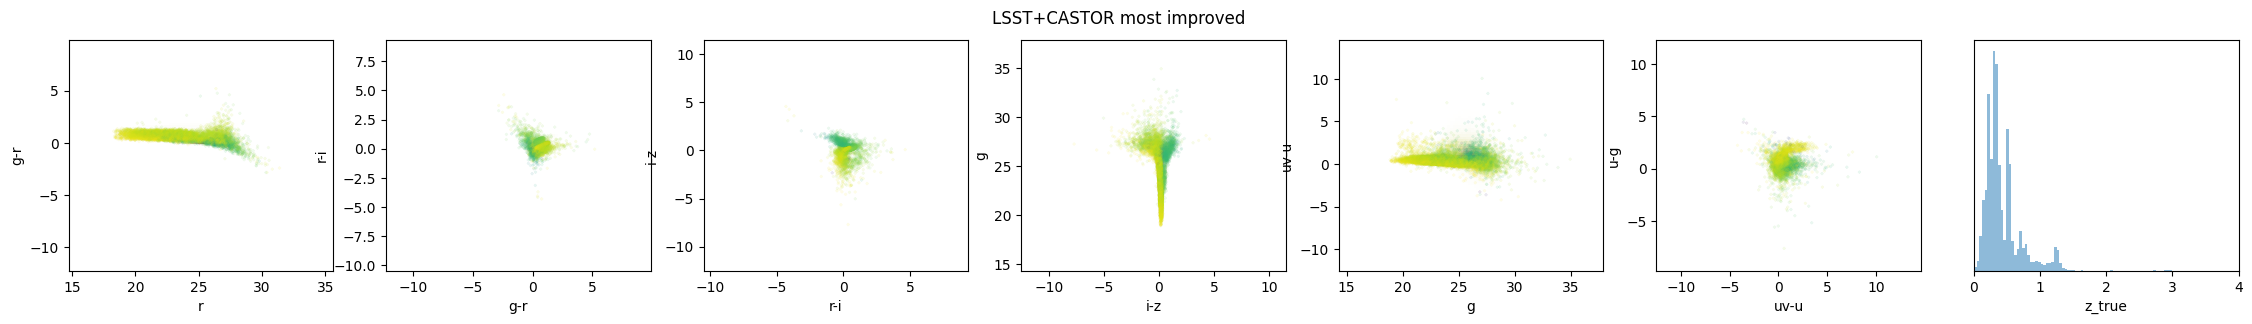

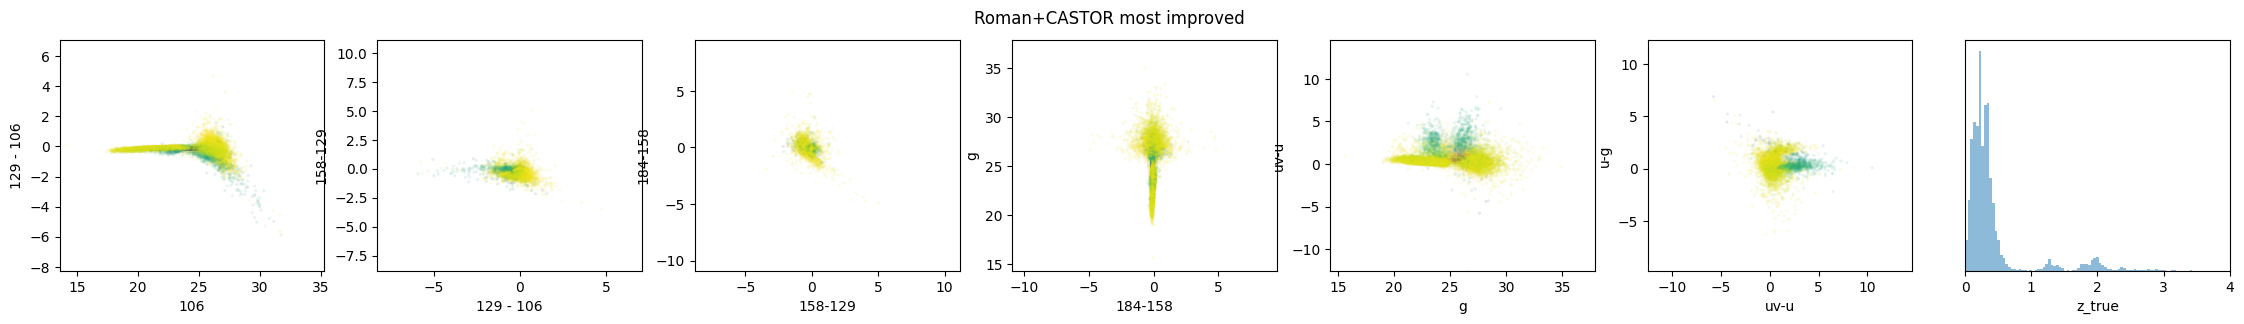

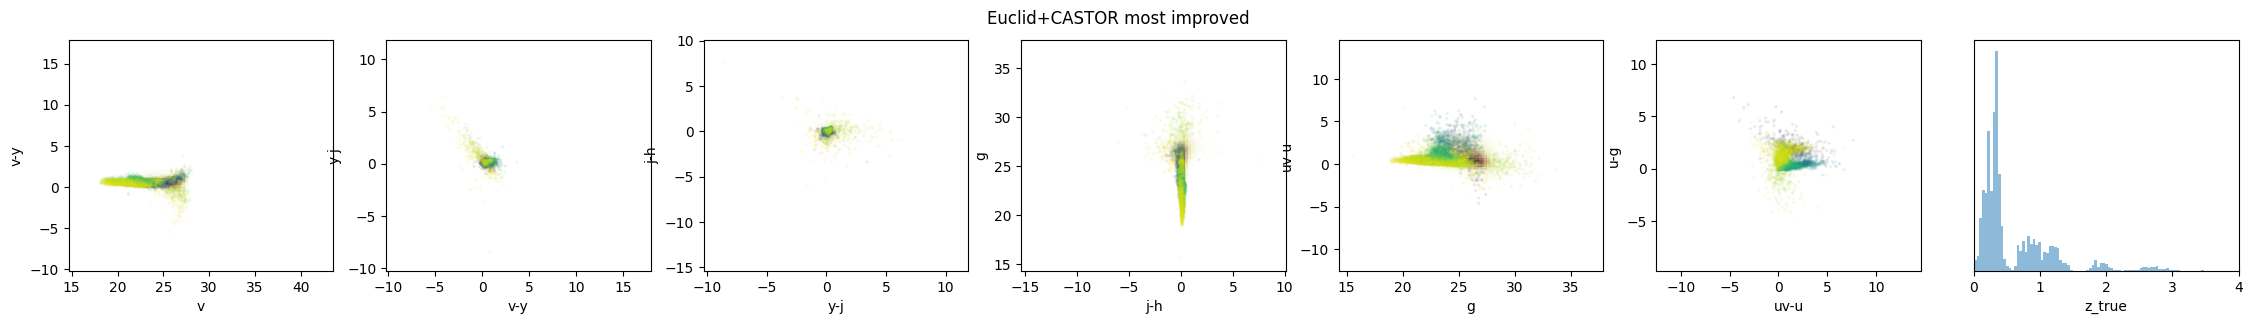

In [31]:
print('most improved defined by cutoff in KLD (more than a tenth of a percentile for sure!)')

for j, os in enumerate(['LSST+CASTOR', 'Roman+CASTOR', 'Euclid+CASTOR']):
  subset = tav_cats[os].drop(['z_true', 'log_prob'], axis=1)
  tot_plots = len(subset.columns)
  fig, ax = plt.subplots(1, tot_plots, figsize = (tot_plots * 4, 3))
  fig.suptitle(os+' most improved')
  for i, color_col in enumerate(subset.columns.values[:-1]):
    ax[i].hist2d(tav_cats[os][color_col], tav_cats[os][subset.columns[i+1]], cmap='pink_r', bins=(100, 100))
    ax[i].scatter(tav_cats[os][color_col][alt_improved[os].index], tav_cats[os][subset.columns[i+1]][alt_improved[os].index],
                  s = 2, marker = 'x', alpha=0.1, c=np.array(tav_cats[os]['z_true'][alt_improved[os].index]), cmap='viridis_r')
    # ax[i].scatter(tav_cats[os][color_col][worsened[os].index], tav_cats[os][subset.columns[i+1]][worsened[os].index], label = os+' worsened', s = 2, marker = '+', alpha = 0.5)
    ax[i].set_xlabel(color_col)
    ax[i].set_ylabel(subset.columns.values[i+1])
  ax[i+1].hist(tav_cats[os]['z_true'][alt_improved[os].index], bins=np.linspace(0, 4, 100), alpha=0.5, density=True)
  # ax[i+1].hist(tav_cats[os]['z_true'][worsened[os].index], bins=np.linspace(0, 4, 100), label = os+' worsened', alpha=0.5, density=True)
  ax[i+1].set_xlabel('z_true')
  ax[i+1].set_yticks([])
  ax[i+1].set_xlim(0, 4)
  # plt.legend()

  # i = i + 1
  fig.show()

In [32]:
# you can even see by eye where these are in color space, largely differing by the overall v and g magnitudes
# indistinguishable from y-j, v-y, j-h, but highly distinct in uv-u, u-g, definitely breaking a degeneracy

os = 'Euclid+CASTOR'

Euclid_lo_z_good = tav_cats[os].loc[alt_improved[os].index][tav_cats[os]['z_true'] < 0.5]
Euclid_lm_z_good = tav_cats[os].loc[alt_improved[os].index][(tav_cats[os]['z_true'] > 0.5) & (tav_cats[os]['z_true'] < 1.5)]
Euclid_hm_z_good = tav_cats[os].loc[alt_improved[os].index][(tav_cats[os]['z_true'] > 1.5) & (tav_cats[os]['z_true'] < 2.5)]
Euclid_hi_z_good = tav_cats[os].loc[alt_improved[os].index][tav_cats[os]['z_true'] > 2.5]

print(Euclid_lo_z_good.index)
print(Euclid_lm_z_good.index)
print(Euclid_hm_z_good.index)
print(Euclid_hi_z_good.index)

Index([   391,    470,    493,    583,    681,    692,    711,   1104,   1204,
         1594,
       ...
       963430, 963545, 963596, 963649, 963956, 964202, 964293, 964351, 964405,
       964426],
      dtype='int64', name='CASTOR_ID', length=7916)
Index([  1587,   2283,   2542,   2713,   3086,   3406,   3444,   3700,   3896,
         4728,
       ...
       962116, 962144, 962279, 962440, 963042, 963172, 963372, 963710, 963735,
       964213],
      dtype='int64', name='CASTOR_ID', length=3423)
Index([  2541,   5219,  10656,  10900,  14477,  14967,  16945,  18233,  19702,
        21889,
       ...
       943902, 944877, 945313, 945863, 948644, 949826, 951135, 955644, 958539,
       963791],
      dtype='int64', name='CASTOR_ID', length=453)
Index([  1257,   1628,   5942,  19892,  22368,  24206,  24584,  25195,  29567,
        30049,
       ...
       947289, 948611, 949924, 951270, 951815, 953789, 954754, 958900, 959554,
       960600],
      dtype='int64', name='CASTOR_ID', length

<ipython-input-32-44d13ac6404b>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Euclid_lo_z_good = tav_cats[os].loc[alt_improved[os].index][tav_cats[os]['z_true'] < 0.5]
<ipython-input-32-44d13ac6404b>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Euclid_lm_z_good = tav_cats[os].loc[alt_improved[os].index][(tav_cats[os]['z_true'] > 0.5) & (tav_cats[os]['z_true'] < 1.5)]
<ipython-input-32-44d13ac6404b>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Euclid_hm_z_good = tav_cats[os].loc[alt_improved[os].index][(tav_cats[os]['z_true'] > 1.5) & (tav_cats[os]['z_true'] < 2.5)]
<ipython-input-32-44d13ac6404b>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Euclid_hi_z_good = tav_cats[os].loc[alt_improved[os].index][tav_cats[os]['z_true'] > 2.5]


In [33]:
# not well-distinguished in 129-106 nor 158-129 nor 184-158
# actually kind of distinct in 129-106 and overlapping in 106 and g
# however, distinct in g and uv-u, hence CASTOR breaks degeneracy

os = 'Roman+CASTOR'

Roman_lo_z_good = tav_cats[os].loc[alt_improved[os].index][tav_cats[os]['z_true'] < 1.]
Roman_mid_z_good = tav_cats[os].loc[alt_improved[os].index][(tav_cats[os]['z_true'] > 1.) & (tav_cats[os]['z_true'] < 1.5)]
Roman_hi_z_good = tav_cats[os].loc[alt_improved[os].index][tav_cats[os]['z_true'] > 1.5]

print(Roman_lo_z_good.index)
print(Roman_mid_z_good.index)
print(Roman_hi_z_good.index)

Index([     3,     51,    132,    147,    200,    470,    583,    656,    692,
          711,
       ...
       963430, 963448, 963502, 963649, 963670, 963731, 963956, 964202, 964293,
       964405],
      dtype='int64', name='CASTOR_ID', length=9495)
Index([  7385,   8522,  10575,  19900,  30086,  34418,  34867,  39330,  42191,
        49076,
       ...
       946037, 946266, 946714, 950905, 951220, 952377, 953108, 959343, 962388,
       963172],
      dtype='int64', name='CASTOR_ID', length=316)
Index([   538,   1964,   5219,   7488,   8197,   8396,   8856,  11583,  11763,
        11970,
       ...
       954560, 956175, 956407, 958021, 958539, 959037, 960920, 961274, 962431,
       963134],
      dtype='int64', name='CASTOR_ID', length=740)


<ipython-input-33-6d2a93817d99>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Roman_lo_z_good = tav_cats[os].loc[alt_improved[os].index][tav_cats[os]['z_true'] < 1.]
<ipython-input-33-6d2a93817d99>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Roman_mid_z_good = tav_cats[os].loc[alt_improved[os].index][(tav_cats[os]['z_true'] > 1.) & (tav_cats[os]['z_true'] < 1.5)]
<ipython-input-33-6d2a93817d99>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Roman_hi_z_good = tav_cats[os].loc[alt_improved[os].index][tav_cats[os]['z_true'] > 1.5]


### first idea: stratify by absolute value of delta tav, select top 1000 of each

In [46]:
# least_improved_Euclid = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST'])))[::-1]
# least_improved_CASTOR = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))[::-1]

# most_improved_Euclid = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST'])))
# most_improved_CASTOR = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))

# plt.hist(np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST']), alpha=0.25, label= 'Euclid + LSST', density=True, bins=np.linspace(0, 4, 100))
# plt.hist(np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR']), alpha=0.25, label= 'LSST+CASTOR', density=True, bins=np.linspace(0, 4, 100))

# plt.legend()
# plt.xlim(0, 4)
# plt.xlabel(r'$\Delta$' + chr(0x05ea)) #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
# plt.yticks([])
# plt.show()

In [ ]:
worst_galaxies_Euclid = np.argsort((np.abs(just_tav['Euclid+LSST'])))[::-1][0:1000]
worst_galaxies_CASTOR = np.argsort((np.abs(just_tav['LSST+CASTOR'])))[::-1][0:1000]

best_galaxies_Euclid = np.argsort((np.abs(just_tav['Euclid+LSST'])))[0:1000]
best_galaxies_CASTOR = np.argsort((np.abs(just_tav['LSST+CASTOR'])))[0:1000]

colors of best and worst just for castor

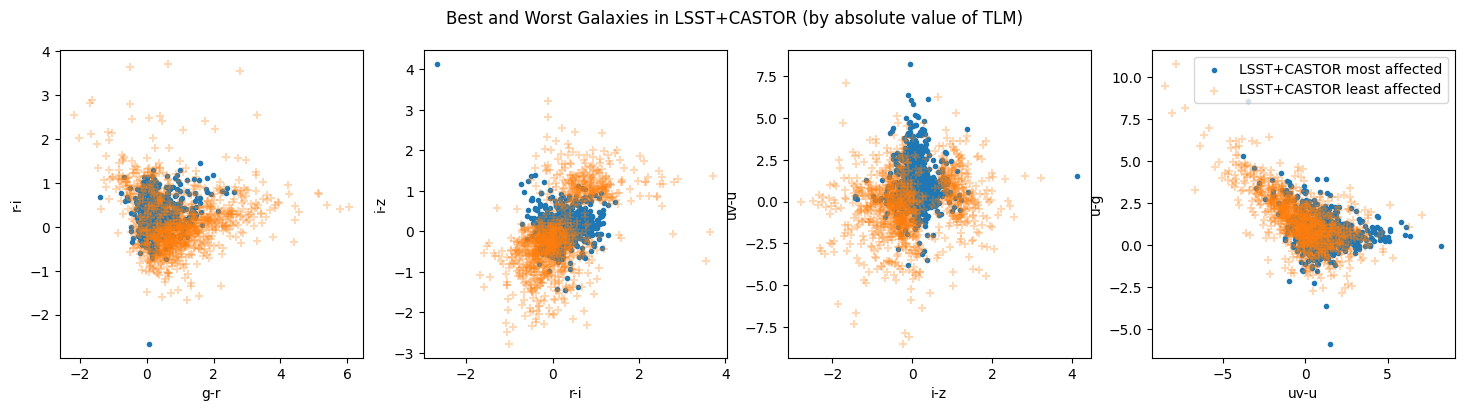

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (18, 4))

i=1

colors_lsst = ['g-r', 'r-i', 'i-z', 'uv-u', 'u-g']

plt.suptitle('Best and Worst Galaxies in LSST+CASTOR (by absolute value of TLM)')

for color, ax in zip(colors_lsst, ax.reshape(-1)):
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[best_galaxies_CASTOR], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[best_galaxies_CASTOR], label = 'LSST+CASTOR most affected', marker = '.')
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[worst_galaxies_CASTOR], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[worst_galaxies_CASTOR], label = 'LSST+CASTOR least affected', marker = '+', alpha = 0.3)

  ax.set_xlabel(color)
  ax.set_ylabel(colors_lsst[i])

  plt.legend()

  i = i + 1

colors for most and least affected just with Euclid+LSST

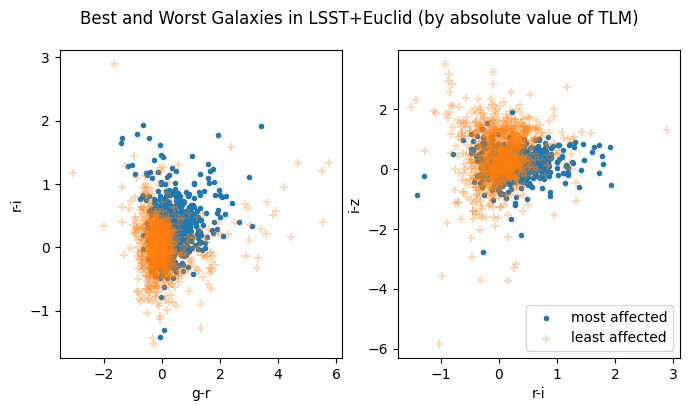

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

i=1

colors_lsst = ['g-r', 'r-i', 'i-z']

plt.suptitle('Best and Worst Galaxies in LSST+Euclid (by absolute value of TLM)')

for color, ax in zip(colors_lsst, ax.reshape(-1)):
  ax.scatter(np.array(catalogs['Euclid+LSST'][color])[best_galaxies_Euclid], np.array(catalogs['Euclid+LSST'][colors_lsst[i]])[best_galaxies_Euclid], label = 'most affected', marker = '.')
  ax.scatter(np.array(catalogs['Euclid+LSST'][color])[worst_galaxies_Euclid], np.array(catalogs['Euclid+LSST'][colors_lsst[i]])[worst_galaxies_Euclid], label = 'least affected', marker = '+', alpha = 0.3)

  ax.set_xlabel(color)
  ax.set_ylabel(colors_lsst[i])

  plt.legend()

  i = i + 1

In [ ]:
worst_galaxies_Euclid = np.argsort((np.abs(just_tav['Euclid+LSST'])))[::-1][0:1000]
worst_galaxies_CASTOR = np.argsort((np.abs(just_tav['LSST+CASTOR'])))[::-1][0:1000]

best_galaxies_Euclid = np.argsort((np.abs(just_tav['Euclid+LSST'])))[0:1000]
best_galaxies_CASTOR = np.argsort((np.abs(just_tav['LSST+CASTOR'])))[0:1000]

In [ ]:
best_galaxies_Euclid = np.argsort((np.abs(just_tav['Euclid+LSST'])))[0:1000]
best_galaxies_CASTOR = np.argsort((np.abs(just_tav['LSST+CASTOR'])))[0:1000]

In [ ]:
print(np.sum(worst_galaxies_Euclid == worst_galaxies_CASTOR))
print(np.sum(best_galaxies_Euclid == best_galaxies_CASTOR))

2
0


colors of most affected in both

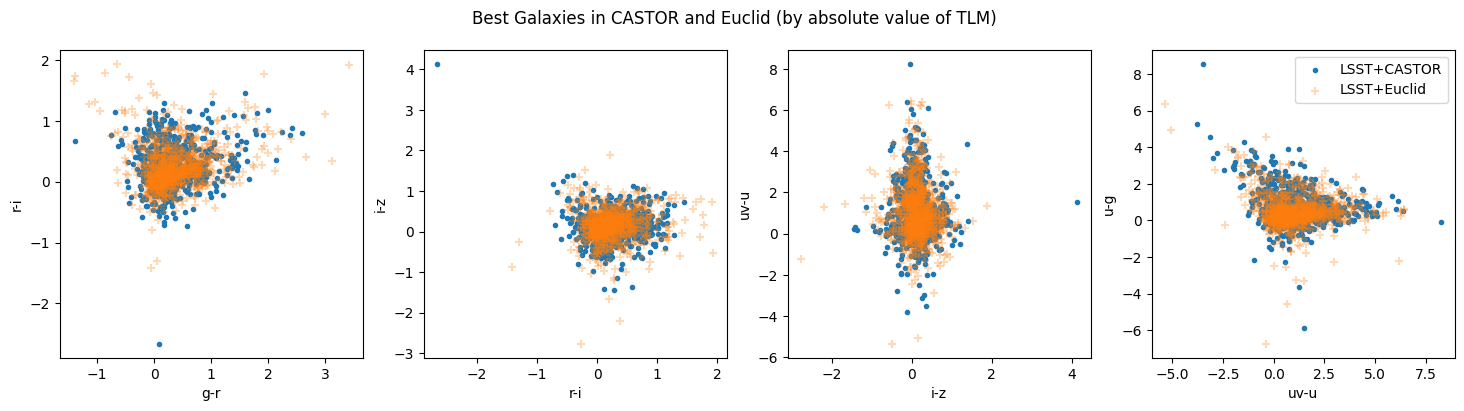

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (18, 4))

i=1

colors_lsst = ['g-r', 'r-i', 'i-z', 'uv-u', 'u-g']

plt.suptitle('Best Galaxies in CASTOR and Euclid (by absolute value of TLM)')

for color, ax in zip(colors_lsst, ax.reshape(-1)):
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[best_galaxies_CASTOR], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[best_galaxies_CASTOR], label = 'LSST+CASTOR', marker = '.')
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[best_galaxies_Euclid], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[best_galaxies_Euclid], label = 'LSST+Euclid', marker = '+', alpha = 0.3)

  ax.set_xlabel(color)
  ax.set_ylabel(colors_lsst[i])

  plt.legend()

  i = i + 1

colors of least affected in both

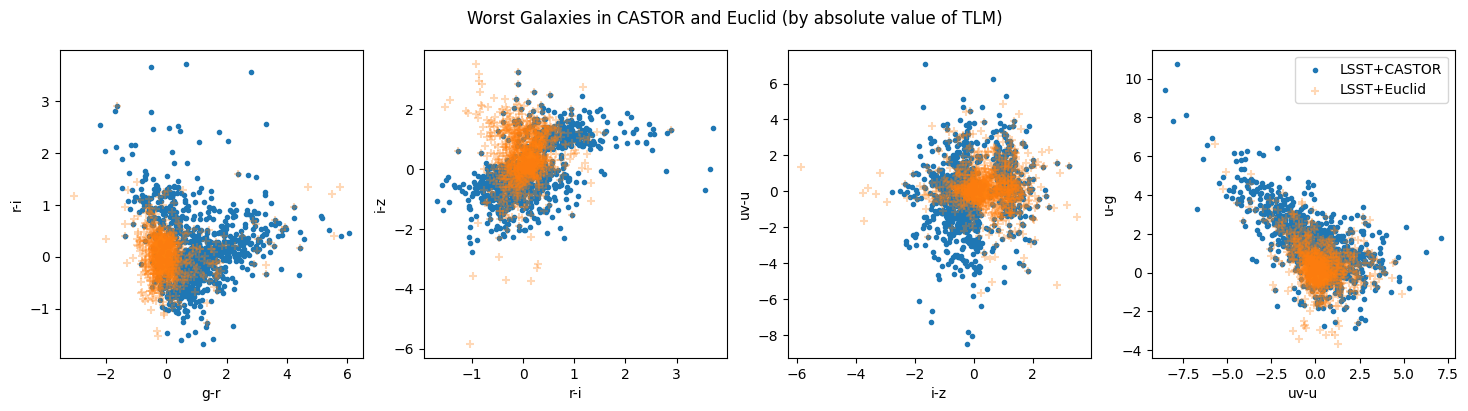

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (18, 4))

i=1

colors_lsst = ['g-r', 'r-i', 'i-z', 'uv-u', 'u-g']

plt.suptitle('Worst Galaxies in CASTOR and Euclid (by absolute value of TLM)')

for color, ax in zip(colors_lsst, ax.reshape(-1)):
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[worst_galaxies_CASTOR], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[worst_galaxies_CASTOR], label = 'LSST+CASTOR', marker = '.')
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[worst_galaxies_Euclid], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[worst_galaxies_Euclid], label = 'LSST+Euclid', marker = '+', alpha = 0.3)

  ax.set_xlabel(color)
  ax.set_ylabel(colors_lsst[i])

  plt.legend()

  i = i + 1

In [ ]:
worst_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))[::-1][0:1000]
best_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))[0:1000]

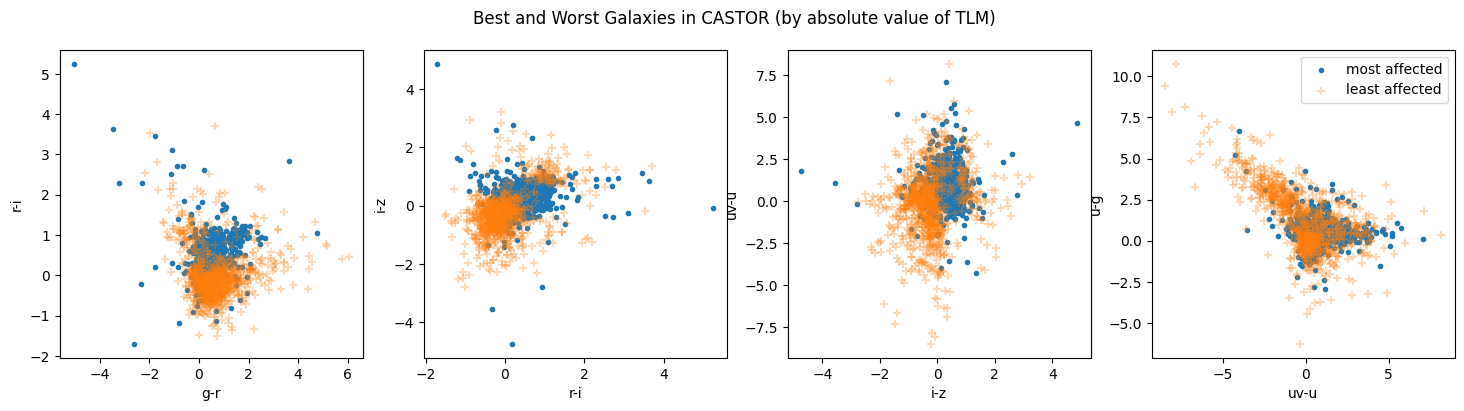

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (18, 4))

i=1

colors_lsst = ['g-r', 'r-i', 'i-z', 'uv-u', 'u-g']

plt.suptitle('Best and Worst Galaxies in CASTOR (by absolute value of TLM)')

for color, ax in zip(colors_lsst, ax.reshape(-1)):
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[best_galaxies], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[best_galaxies], label = 'most affected', marker = '.')
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[worst_galaxies], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[worst_galaxies], label = 'least affected', marker = '+', alpha = 0.3)

  ax.set_xlabel(color)
  ax.set_ylabel(colors_lsst[i])

  plt.legend()

  i = i + 1


## Attempts to Stratify by Clustering

### DBSCAN seems better than the tSNE experiments, so leaving out the tSNE stuff - might be worth returning to.

In [ ]:
# attempts to stratify by clustering

from sklearn.datasets import make_blobs

centers = [[1, 1], [-1, -1], [1, -1]]

X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

In [ ]:
worst_Euclid = np.array([np.array(catalogs['Euclid+LSST']['g-r'])[worst_galaxies_Euclid], np.array(catalogs['Euclid+LSST']['r-i'])[worst_galaxies_Euclid]]).T

plt.scatter(worst_Euclid[:,0], worst_Euclid[:,1])

In [ ]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.06, min_samples=10).fit(worst_Euclid)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

In [ ]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = worst_Euclid[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = worst_Euclid[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

## Attempts to Stratify by Quantiles

In [ ]:
import seaborn as sns

import scipy.stats

In [ ]:
delta_tav_array = np.array([np.abs(just_tav['Euclid+LSST'] - just_tav['LSST-only']), np.abs(just_tav['LSST+CASTOR'] - just_tav['LSST-only'])]).T

tav_df = pd.DataFrame(delta_tav_array, columns = ['Euclid', 'CASTOR'])

sns.jointplot(data=tav_df.sample(30000), x="Euclid", y="CASTOR",  kind="kde")
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.show()

In [ ]:
delta_tav_array = np.array([- just_tav['LSST-only'] + just_tav['LSST+CASTOR'], catalogs['LSST+CASTOR']['uv-u']]).T

tav_df_CASTOR = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'uv-u'])

sns.jointplot(tav_df_Euclid, x='uv-u', y="delta tav", kind = 'kde')

In [ ]:
quants = np.linspace(0,1, 100)
print(quants)

In [ ]:
delta_tav_array = np.array([- just_tav['LSST-only'] + just_tav['LSST+CASTOR'], catalogs['LSST+CASTOR']['u-g'], catalogs['LSST+CASTOR']['g-r'], catalogs['LSST+CASTOR']['z_true']]).T

tav_df_CASTOR = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'u-g', 'g-r', 'z_true'])

tav_df_CASTOR_z_ge_15 = tav_df_CASTOR[tav_df_CASTOR['z_true'] >= 1.5]
tav_df_CASTOR_z_less_15 = tav_df_CASTOR[tav_df_CASTOR['z_true'] < 1.5]


quants_ge_15 = scipy.stats.mstats.mquantiles(tav_df_CASTOR_z_ge_15['delta tav'], quants)
quants_less_15 = scipy.stats.mstats.mquantiles(tav_df_CASTOR_z_less_15['delta tav'], quants)

plt.scatter(quants_less_15, quants_ge_15)

x = np.linspace(np.min(quants_ge_15), np.max(quants_ge_15), 10)
y = x

plt.plot(x, y)
plt.xlim(0, 4)
plt.ylim(0, 4)

plt.title('quantile-quantile plot of $\Delta$TLM, z > 1.5 vs z < 1.5')
plt.xlabel('$\Delta$TLM z < 1.5')
plt.ylabel('$\Delta$TLM z > 1.5')


plt.grid()

In [ ]:
delta_tav_array = np.array([- just_tav['LSST-only'] + just_tav['LSST+CASTOR'], catalogs['LSST+CASTOR']['u-g'], catalogs['LSST+CASTOR']['g-r'], catalogs['LSST+CASTOR']['z_true']]).T

tav_df_CASTOR = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'u-g', 'g-r', 'z_true'])

tav_df_CASTOR_z_ge_15 = tav_df_CASTOR[tav_df_CASTOR['z_true'] >= 1.5]
tav_df_CASTOR_z_less_15 = tav_df_CASTOR[tav_df_CASTOR['z_true'] < 1.5]


quants_ge_15 = scipy.stats.mstats.mquantiles(tav_df_CASTOR_z_ge_15['g-r'], quants)
quants_less_15 = scipy.stats.mstats.mquantiles(tav_df_CASTOR_z_less_15['g-r'], quants)

plt.scatter(quants_less_15, quants_ge_15)

x = np.linspace(np.min(quants_ge_15), np.max(quants_ge_15), 10)
y = x

plt.plot(x, y)
plt.xlim(0, 4)
plt.ylim(0, 4)

plt.grid()

plt.title('quantile-quantile plot of g-r, z > 1.5 vs z < 1.5')

plt.xlabel('g-r z < 1.5')
plt.ylabel('g-r z > 1.5')

In [ ]:
delta_tav_array = np.array([- just_tav['LSST-only'] + just_tav['LSST+CASTOR'], catalogs['LSST+CASTOR']['u-g'], catalogs['LSST+CASTOR']['g-r'], catalogs['LSST+CASTOR']['z_true']]).T

tav_df_CASTOR = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'u-g', 'g-r', 'z_true'])

tav_df_CASTOR_z_ge_15 = tav_df_CASTOR[tav_df_CASTOR['z_true'] >= 1.5]
tav_df_CASTOR_z_less_15 = tav_df_CASTOR[tav_df_CASTOR['z_true'] < 1.5]


quants_ge_15 = scipy.stats.mstats.mquantiles(tav_df_CASTOR_z_ge_15['u-g'], quants)
quants_less_15 = scipy.stats.mstats.mquantiles(tav_df_CASTOR_z_less_15['u-g'], quants)

plt.scatter(quants_less_15, quants_ge_15)

x = np.linspace(np.min(quants_ge_15), np.max(quants_ge_15), 10)
y = x

plt.plot(x, y)
plt.xlim(0, 4)
plt.ylim(0, 4)

plt.title('quantile-quantile plot of u-g, z > 1.5 vs z < 1.5')
plt.grid()

plt.xlabel('u-g z < 1.5')
plt.ylabel('u-g z > 1.5')

In [ ]:
delta_tav_array_abs_LSST = np.array([just_tav['LSST-only'], catalogs['LSST+CASTOR']['u-g'], catalogs['LSST+CASTOR']['g-r'], catalogs['LSST+CASTOR']['z_true']]).T
delta_tav_array_CASTOR = np.array([just_tav['LSST+CASTOR'], catalogs['LSST+CASTOR']['u-g'], catalogs['LSST+CASTOR']['g-r'], catalogs['LSST+CASTOR']['z_true']]).T


tav_df_abs_LSST = pd.DataFrame(delta_tav_array_abs_LSST, columns = ['delta tav', 'u-g', 'g-r', 'z_true'])
tav_df_abs_CASTOR = pd.DataFrame(delta_tav_array_CASTOR, columns = ['delta tav', 'u-g', 'g-r', 'z_true'])


# tav_df_CASTOR_z_ge_15 = tav_df_CASTOR[tav_df_CASTOR['z_true'] >= 1.5]
# tav_df_CASTOR_z_less_15 = tav_df_CASTOR[tav_df_CASTOR['z_true'] < 1.5]


quants_LSST = scipy.stats.mstats.mquantiles(tav_df_abs_LSST['delta tav'], quants)
quants_CASTOR = scipy.stats.mstats.mquantiles(tav_df_abs_CASTOR['delta tav'], quants)

plt.scatter(quants_LSST, quants_CASTOR)

x = np.linspace(np.min(quants_LSST), np.max(quants_CASTOR), 10)
y = x

plt.plot(x, y)
plt.xlim(0, 4)
plt.ylim(0, 4)

plt.title('quantile-quantile plot of TLM, LSST vs LSST+ CASTOR')
plt.xlabel('LSST')
plt.ylabel('LSST + CASTOR')


plt.grid()

In [ ]:
sns.violinplot(x=tav_df_CASTOR["delta tav"])
plt.show()
sns.boxenplot(x=tav_df_CASTOR["delta tav"])
plt.show()
sns.violinplot(x=tav_df_Euclid["delta tav"])
plt.show()
sns.boxenplot(x=tav_df_Euclid["delta tav"])

In [ ]:
# split by TLM value

delta_tav_array = np.array([- just_tav['LSST-only'] + just_tav['LSST+CASTOR'], catalogs['LSST+CASTOR']['u-g'], catalogs['LSST+CASTOR']['g-r'], catalogs['LSST+CASTOR']['z_true']]).T

tav_df_CASTOR = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'u-g', 'g-r', 'z_true'])

sns.jointplot(tav_df_CASTOR[tav_df_CASTOR['delta tav']> 2], x='u-g', y="g-r", kind = 'kde')

plt.ylim(-1, 3)
plt.xlim(-1, 3)

sns.jointplot(tav_df_CASTOR[tav_df_CASTOR['delta tav']< 2], x='u-g', y="g-r", kind = 'kde')

plt.ylim(-1, 3)
plt.xlim(-1, 3)

In [ ]:
# adding some representative points

gr = tav_df_CASTOR_z_cut[tav_df_CASTOR_z_cut['delta tav'] > 2].sort_values(by = ['delta tav'], ascending = False)[0:15]['g-r']
ug = tav_df_CASTOR_z_cut[tav_df_CASTOR_z_cut['delta tav'] > 2].sort_values(by = ['delta tav'], ascending = False)[0:15]['u-g']

In [ ]:
# split by "pivot" redshift

delta_tav_array = np.array([- just_tav['LSST-only'] + just_tav['LSST+CASTOR'], catalogs['LSST+CASTOR']['u-g'], catalogs['LSST+CASTOR']['g-r'], catalogs['LSST+CASTOR']['z_true']]).T

tav_df_CASTOR = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'u-g', 'g-r', 'z_true'])
tav_df_CASTOR_z_cut = tav_df_CASTOR[tav_df_CASTOR['z_true']> 1.5]

sns.jointplot(tav_df_CASTOR_z_cut[tav_df_CASTOR_z_cut['delta tav']> 2], x='u-g', y="g-r", kind = 'kde')

plt.scatter(ug, gr)

plt.ylim(-1, 3)
plt.xlim(-1.5, 5.5)

sns.jointplot(tav_df_CASTOR_z_cut[tav_df_CASTOR_z_cut['delta tav']< 2], x='u-g', y="g-r", kind = 'kde')

plt.ylim(-1, 3)
plt.xlim(-1.5, 5.5)